# Generate some synthetic regression data

<IPython.core.display.Javascript object>


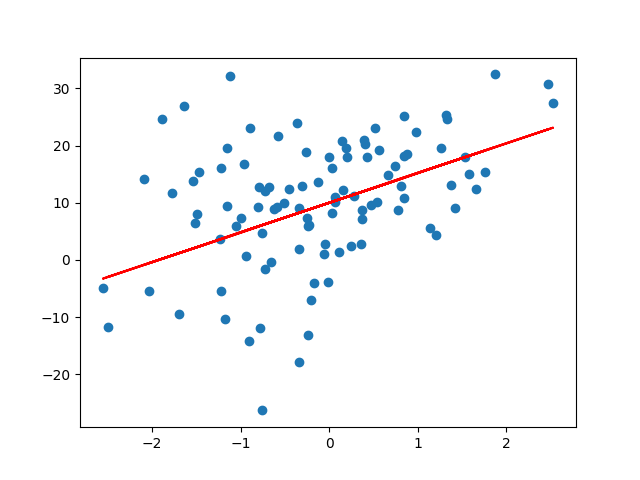

In [3]:
from sklearn.datasets import make_regression
from matplotlib import pyplot
import numpy as np
%matplotlib notebook

# generate regression dataset
bias = 10
X, y, coeff = make_regression(n_samples=100, n_features=1, noise=10., coef=True, bias=bias)

# plot regression dataset
pyplot.scatter(X,y)
pyplot.show()
pyplot.plot(X , coeff*X + bias, 'r')

# Now lets fit the data using ordinary least square (no standarization)

In [4]:
import statsmodels.api as sm

### For ordinary least square, without any regularization, scaling is not required (results are scale independent). Standardization is necessary if regularization is present

In [5]:
Xols = sm.add_constant(X)
model = sm.OLS(y, Xols)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     18.56
Date:                Wed, 27 Feb 2019   Prob (F-statistic):           3.92e-05
Time:                        15:20:33   Log-Likelihood:                -374.91
No. Observations:                 100   AIC:                             753.8
Df Residuals:                      98   BIC:                             759.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.7322      1.047     10.252      0.0

Confidence [.025 .975]
2.5% values lower than this
97.5% value higher than this
confidence bound = 1 - 2*2.5 = 95% (2.5% on both sides.)

<IPython.core.display.Javascript object>


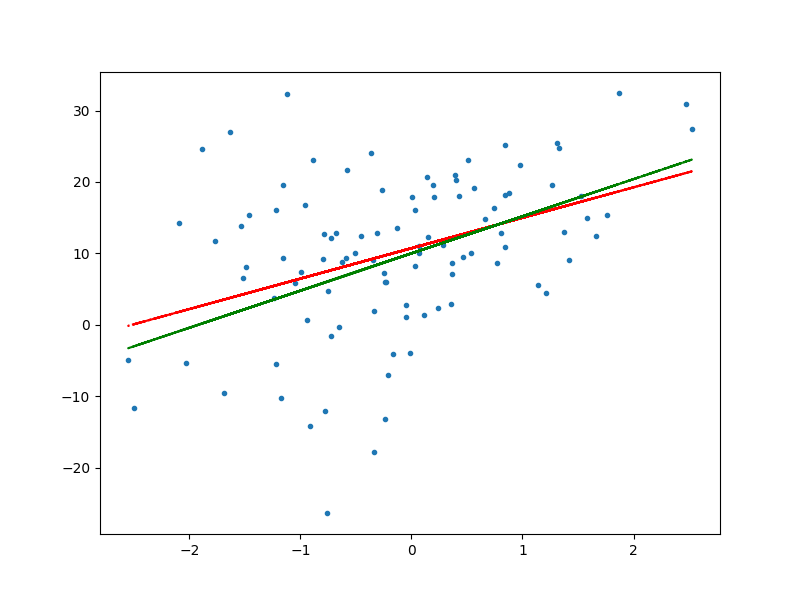

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(X, y, '.', label="data")
ax.plot(X, results.fittedvalues, 'r-.', label="OLS")
ax.plot(X, coeff*X + bias, 'g-.', label="True")

### ESL: equation 3.8 to compute $\hat{\sigma}^2$

In [7]:
p = 1
N = np.shape(y)[0]

sigma_hat_2 = np.sum((y - results.fittedvalues)**2)/float(N - p - 1)

### ESL: equation 3.12 to compute Z-score

In [8]:
from numpy.linalg import inv
XTX = Xols.T.dot(Xols)
XTX_inv = inv(XTX)
v0 = XTX_inv[0,0]

z0 = results.params[0]/np.sqrt(sigma_hat_2*v0)
print('z0 =',z0)

z0 = 10.2517122877286


In [9]:
from numpy.linalg import inv
XTX = Xols.T.dot(Xols)
XTX_inv = inv(XTX)
v1 = XTX_inv[1,1]

z1 = results.params[1]/np.sqrt(sigma_hat_2*v1)
print('z1 =',z1)

z1 = 4.307594186057561


### ESL: equation 3.13 to compute F statistics = $\frac{(RSS_0-RSS_1)/(p1-p0)}{RSS1/(N-p1-1)}$

#### Full model y = $\beta_0 + \beta_1*X$
#### Reduced model y = $\beta_0$

In [10]:
## Full model
full_model = sm.OLS(y, sm.add_constant(X))
full_model_res = full_model.fit()

## Reduced model
reduced_model = sm.OLS(y, sm.add_constant(X)[:,0])
reduced_model_res = reduced_model.fit()

In [11]:
p1 = 1
p0 = 0
RSS1 = np.sum((y - full_model_res.fittedvalues)**2)
RSS0 = np.sum((y - reduced_model_res.fittedvalues)**2) ## Just the intercept model

In [12]:
num = (RSS0 - RSS1)/(p1-p0)
den = sigma_hat_2
F = num/den
print('F statistic (',F,')', ' == ','Z^2 (',z1**2,')')

F statistic ( 18.555367671756958 )  ==  Z^2 ( 18.555367671756905 )


#### Full model y = $\beta_0 + \beta_1*X$
#### Reduced model y = $\beta_1*X$

In [13]:
## Full model
full_model = sm.OLS(y, sm.add_constant(X))
full_model_res = full_model.fit()

## Reduced model
reduced_model = sm.OLS(y, X)
reduced_model_res = reduced_model.fit()

In [14]:
p1 = 1
p0 = 0
RSS1 = np.sum((y - full_model_res.fittedvalues)**2)
RSS0 = np.sum((y - reduced_model_res.fittedvalues)**2) ## Just the intercept model

In [15]:
num = (RSS0 - RSS1)/(p1-p0)
den = sigma_hat_2
F = num/den
print('F statistic (',F,')', ' == ','Z^2 (',z0**2,')')

F statistic ( 105.0976048303657 )  ==  Z^2 ( 105.09760483036555 )


### ESL: equation 3.14 to compute confidence intervals

###  Bounds using the z-score (normal distribution assumption)

In [33]:
alpha = .025
z_score = np.array([z0,z1])
v = np.array([v0,v1])
sigma_hat = np.sqrt(sigma_hat_2)
lower_bnds = results.params - 1.96*np.sqrt(v)*sigma_hat
upper_bnds = results.params + 1.96*np.sqrt(v)*sigma_hat
print('Confidence interval for intercept = [',lower_bnds[0],',',upper_bnds[0],']')
print('Confidence intervals from the fit: ',results.conf_int()[0])
print('Confidence interval for slope = [',lower_bnds[1],',',upper_bnds[1],']')
print('Confidence intervals from the fit: ',results.conf_int()[1])

Confidence interval for intercept = [ 8.680376302986266 , 12.784121576211058 ]
Confidence intervals from the fit:  [ 8.65476197 12.80973591]
Confidence interval for slope = [ 2.3210274879875197 , 6.196666560083939 ]
Confidence intervals from the fit:  [2.29683692 6.22085713]


Keep in mind: we are able to use the normal distribution to construct our confidence interval because of the Central Limit Theorem. When n≥30, the sampling distribution of the sample mean becomes normal. If n≤30, the skewness of the population could influence the shape of the sampling distribution and make it not normal.

But what do we do if we want to calculate confidence interval for a sample size where n≤30? 
We use the t-distribution, but only if we feel it is appropriate to assume that the population distribution itself is normal (or close to normal).

Constructing confidence intervals with t-distribution is the same as using the z-distribution, except it replaces the z-score with a t-score.

Here are the fundamental principles for using the t-distribution for confidence intervals:

1. You cannot use the t-distribution unless you assume that the population distribution of the variable is normally distributed.
2. The t-distribution, like the z-distribution, is bell-shaped and symmetric about a mean of 0. 
3. The t-distribution incorporates the fact that for smaller sample sizes the distribution will be more spread out using something called degrees of freedom. For confidence intervals, the degrees of freedom will allways be df=n−1, or one less than the sample size.
4. For every change in degrees of freedom, the t-distribution changes. The larger the sample size (n), the closer the t-distribution mimics the z-distribution in shape. We construct a confidence interval for a small sample size in the same way as we do for a large sample, except we use the t-distribution instead of the z-distribution.
    The formula is: $x \pm t\frac{s}{\sqrt{n}}$
   
    $\textbf{t-distribution has fatter tails than a normal distribution.}$

###  Bounds using the t-score (relaxing the normal distribution assumption)

In [36]:
from scipy import stats
alpha = .025
z_score = np.array([z0,z1])
v = np.array([v0,v1])
sigma_hat = np.sqrt(sigma_hat_2)
lower_bnds = results.params - (stats.t.ppf(1-0.025, N))*np.sqrt(v)*sigma_hat
upper_bnds = results.params + (stats.t.ppf(1-0.025, N))*np.sqrt(v)*sigma_hat
print('Confidence interval for intercept = [',lower_bnds[0],',',upper_bnds[0],']')
print('Confidence intervals from the fit: ',results.conf_int()[0])
print('Confidence interval for slope = [',lower_bnds[1],',',upper_bnds[1],']')
print('Confidence intervals from the fit: ',results.conf_int()[1])

Confidence interval for intercept = [ 8.655281148514403 , 12.809216730682921 ]
Confidence intervals from the fit:  [ 8.65476197 12.80973591]
Confidence interval for slope = [ 2.297327244742397 , 6.220366803329061 ]
Confidence intervals from the fit:  [2.29683692 6.22085713]


### Let's looks at the covariance matrix now

In [50]:
cov_mat = results.cov_params()
print('Covariance matrix = ',cov_mat)

Covariance matrix =  [[1.09594474 0.13129151]
 [0.13129151 0.97749494]]


Covariance matrix = $(\bf{X}^T\bf{X})^{-1}\hat{\sigma}^2$

In [52]:
#Compure (XtX)^1
XTX = Xols.T.dot(Xols)
XTX_inv = inv(XTX)

# Compute sigma_hat^2 
sigma_hat_2 = np.sum((y - results.fittedvalues)**2)/float(N - p - 1)

(XtX)^-1 = [[1.09594474 0.13129151]
 [0.13129151 0.97749494]]


In [57]:
# Compute z-score from covariance matrix
print('Z0 = ',results.params[0]/np.sqrt((cov_mat[0,0])))
print('Z1 = ',results.params[1]/np.sqrt((cov_mat[1,1])))

Z0 =  10.2517122877286
Z1 =  4.307594186057561
